In [1]:
import logging
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time
import pickle
import pyLDAvis
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # for simple pca
from sklearn.decomposition import PCA

In [2]:
# load data
doc_year = [167,196,156,207,249,404,378,
271,
201,
768,
673,
823,
431,
681,
498,
597,
464,
657]

doc_ids =[0]+list(np.cumsum(doc_year))


alldata_new = pickle.load(open('output/20topics_newpreprocess_dict.p', 'rb'))
term_topic = alldata_new['term_topic']# term_topic is n_years*n_topics*n_terms
term_frequency = alldata_new['term_frequency']#term_frequency is n_years*n_terms
terms = alldata_new['terms']#terms is n_terms

doc_topic = []
doc_length=[]
for year in range(len(term_topic)):    
    doc_topic.append(alldata_new['doc_topic'][doc_ids[year]:doc_ids[year+1]])# doc_topic is nyear*n_docs given year*n_topics
    doc_length.append(alldata_new['doc_length'][doc_ids[year]:doc_ids[year+1]]) #doc_length is nyear*n_docs given year

In [4]:
# rename topics by their top freq word
topics = range(term_topic.shape[1])

def topic_label(topic, term_topic, terms):
    term_freqs = np.sum(term_topic[:,topic,:], axis = 0)
    max_term = np.argsort(-term_freqs)[0]
    return(terms[max_term])


topic_labels = [topic_label(topic, term_topic, terms) for topic in topics]
import pandas as pd

with open('output/all_visdtm.p','br') as f:
    allvisdtm=pickle.load(f)
for visdtm in allvisdtm:

    visdtm[0]['topiclabel']=topic_labels
topic_labels

['spatial',
 'face',
 'speaker',
 'action',
 'trial',
 'relational',
 'reasoning',
 'probability',
 'stimulus',
 'concept',
 'speech',
 'child',
 'category',
 'rule',
 'sentence',
 'movement',
 'causal',
 'network',
 'student',
 'decision']

In [5]:
# given a list of paper, what are their main topics? for analyzing like a lab or an author
doclist = [0,1,2]
def maintopics(doclist,*topic_labels):
    ntopics=20
    doc_topfreq=np.empty((len(doclist),ntopics))
    for k in range(len(doclist)):
        doc_topfreq[k]=alldata_new['doc_topic'][doclist[k]]
    doc_topfreq = np.mean(doc_topfreq,axis=0)
    maintopics = np.argsort(-doc_topfreq) 
    doc_topfreq=doc_topfreq[maintopics]
    if topic_labels:
        maintopics=[topic_labels[0][idx-1] for idx in maintopics]
    return (maintopics,doc_topfreq)
maintopics(doclist,topic_labels)
    

(['concept',
  'child',
  'trial',
  'spatial',
  'reasoning',
  'causal',
  'speech',
  'rule',
  'action',
  'stimulus',
  'category',
  'decision',
  'face',
  'network',
  'movement',
  'student',
  'probability',
  'relational',
  'speaker',
  'sentence'],
 array([ 0.31316781,  0.23650612,  0.13431411,  0.04727843,  0.04435809,
         0.04059254,  0.03637174,  0.03510529,  0.03359614,  0.02391579,
         0.0228669 ,  0.01758262,  0.0113545 ,  0.00068805,  0.0004457 ,
         0.00038972,  0.00036661,  0.00036661,  0.00036661,  0.00036661]))

In [4]:
# visualize, each year
allvisdtm = []
for year in range(len(term_topic)):
    # doc related haven't processed.
    vis_dtm = pyLDAvis.prepare(topic_term_dists=term_topic[year], doc_topic_dists=doc_topic[year], doc_lengths=doc_length[year], vocab=terms, term_frequency=term_frequency[year],sort_topics=False)
    if vis_dtm[0]['x'].iloc[0]<0: # always put the first topic to be x>0 ,y>0
        vis_dtm[0]['x'] = -vis_dtm[0]['x']
    if vis_dtm[0]['y'].iloc[0]<0:
        vis_dtm[0]['y'] = -vis_dtm[0]['y']
    allvisdtm.append(vis_dtm)    
    with open("output/visdtm"+str(year+1)+".html", "w") as f:
        pyLDAvis.save_html(vis_dtm, f)
with open('output/all_visdtm.p','bw') as f:
    pickle.dump(allvisdtm,f)

/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/Users/zhiwei/anaconda3/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-in

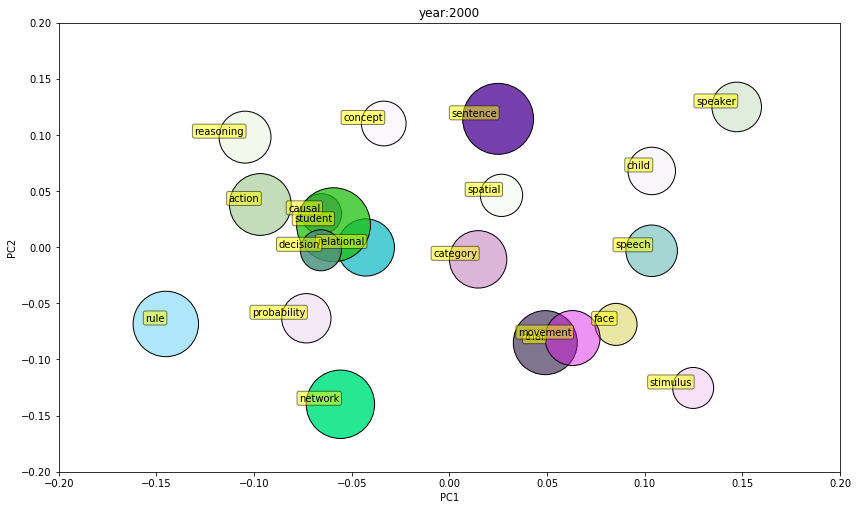

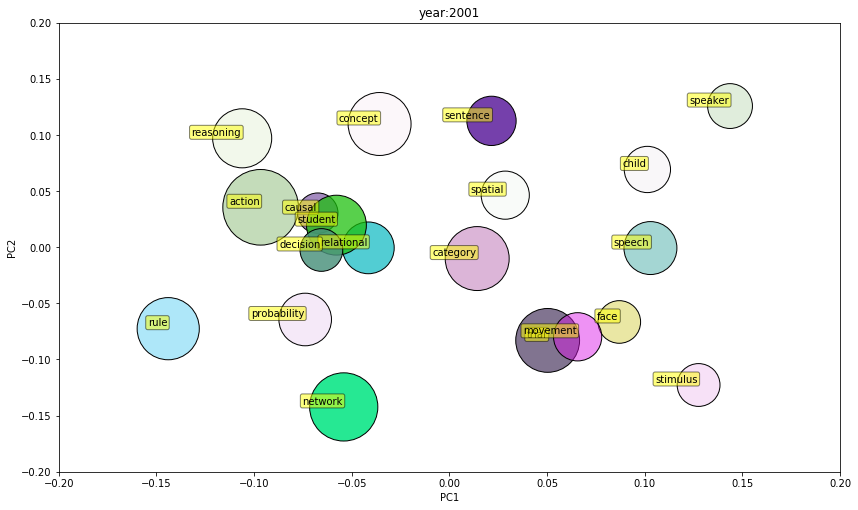

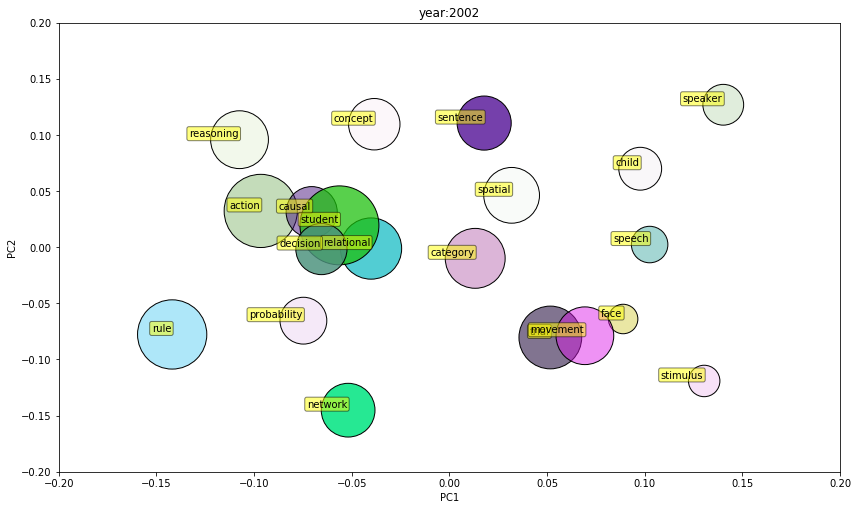

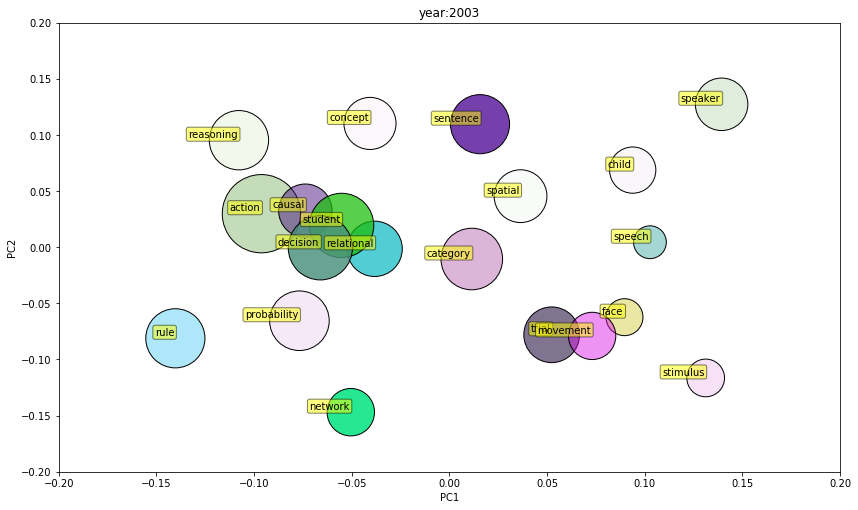

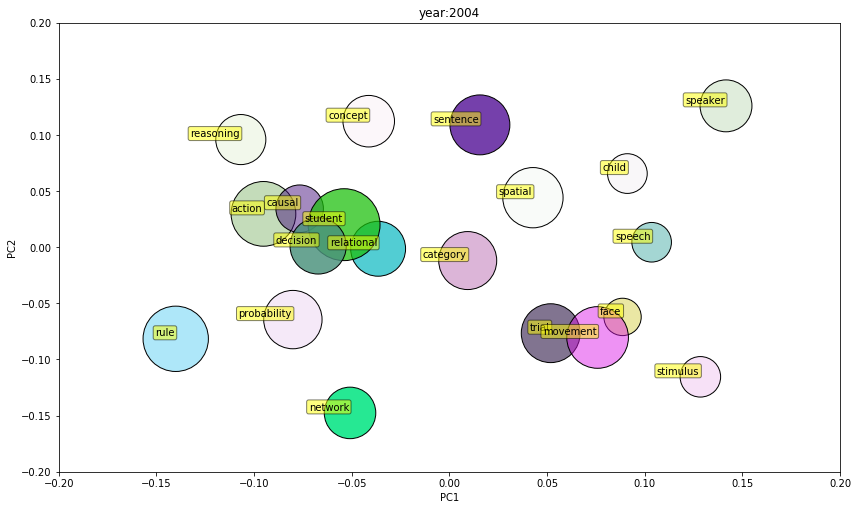

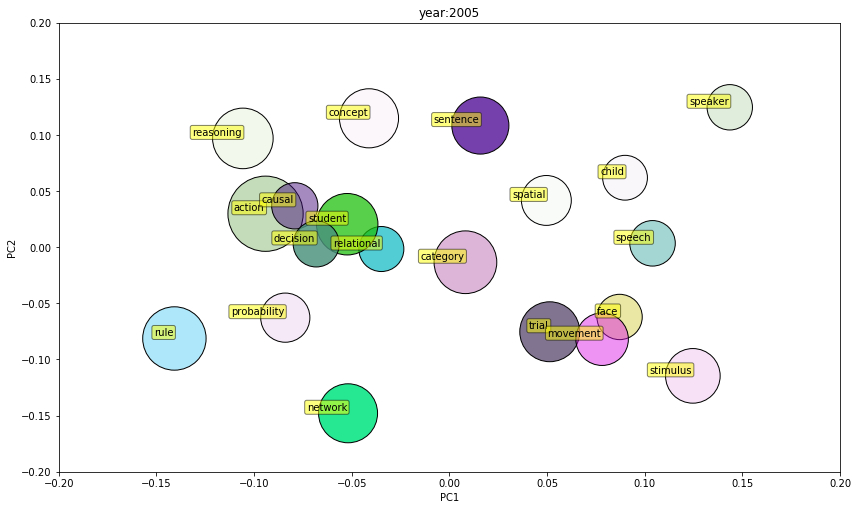

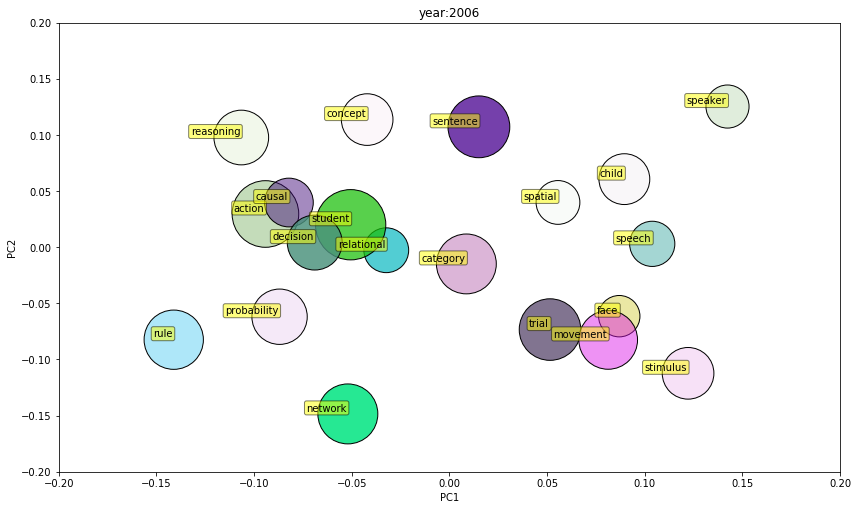

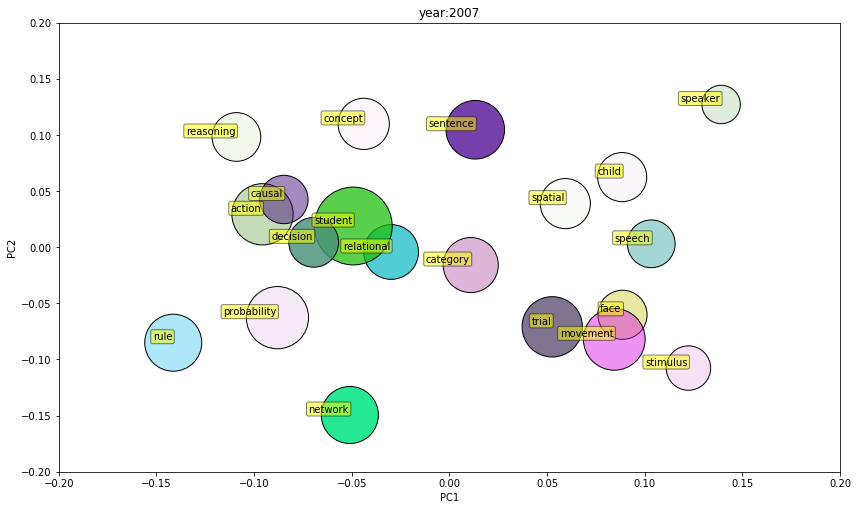

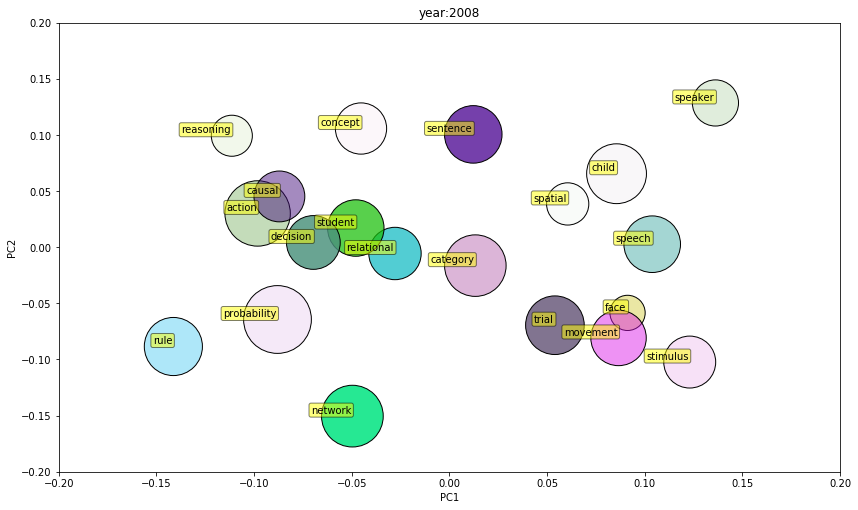

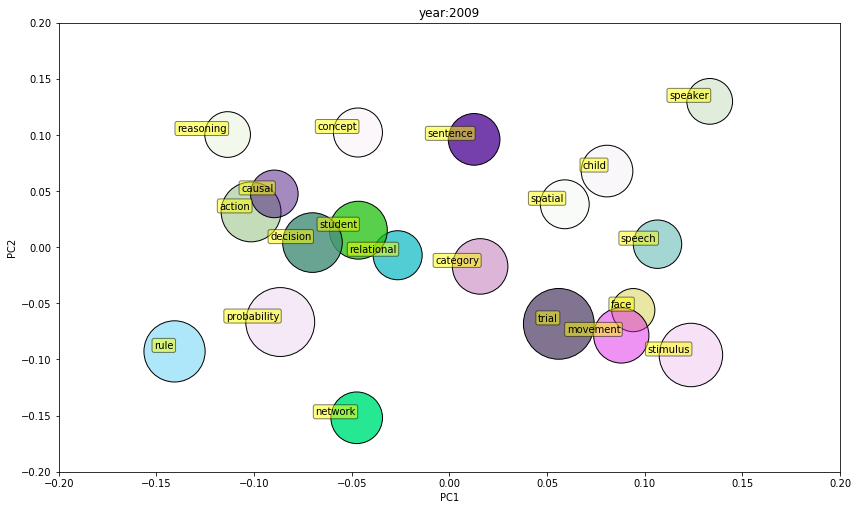

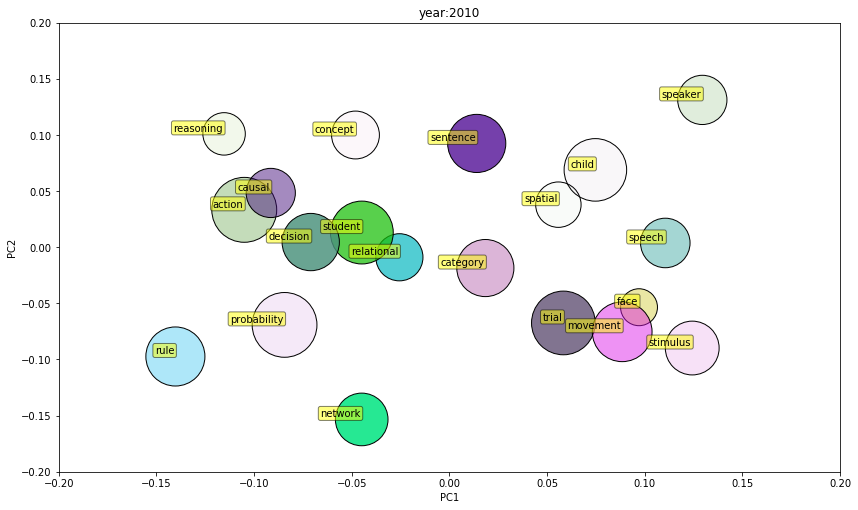

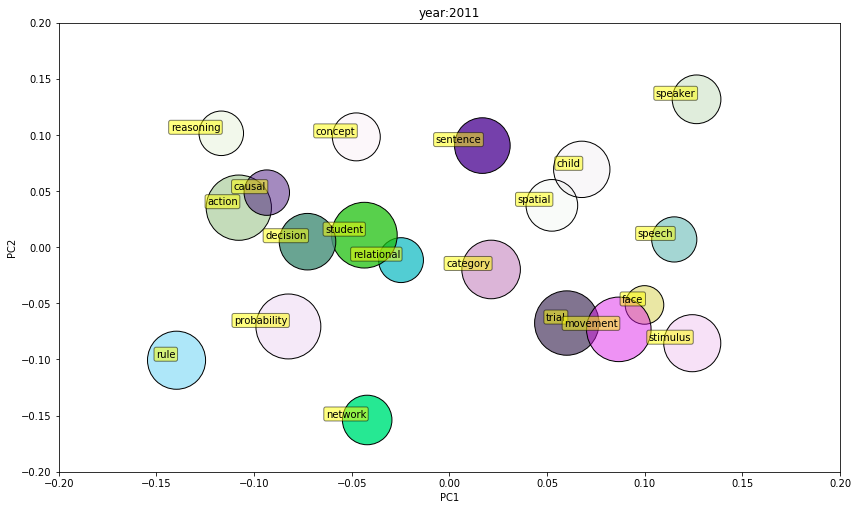

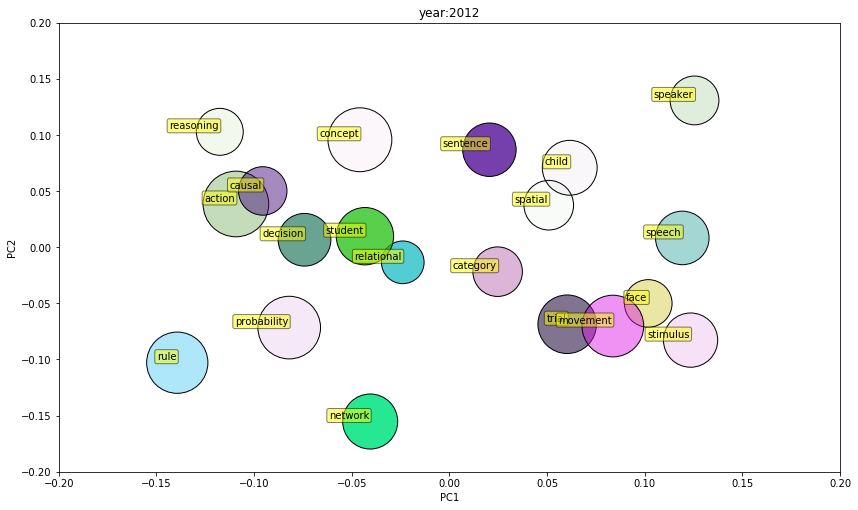

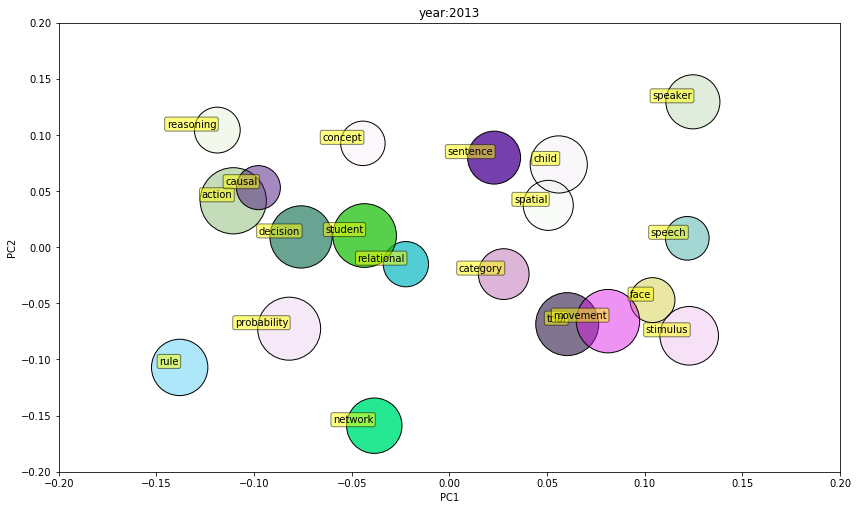

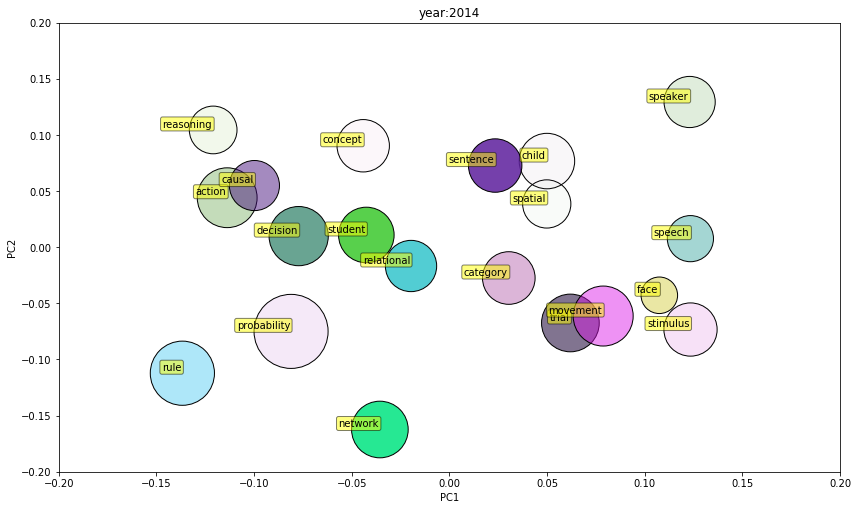

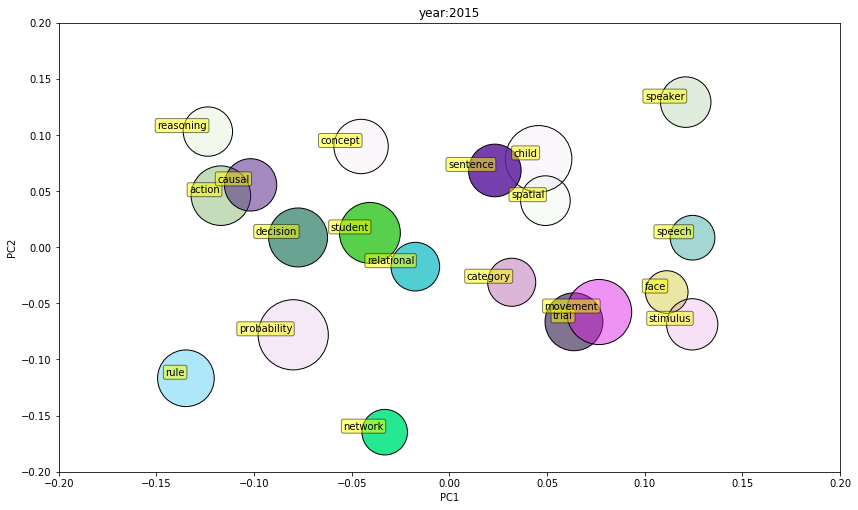

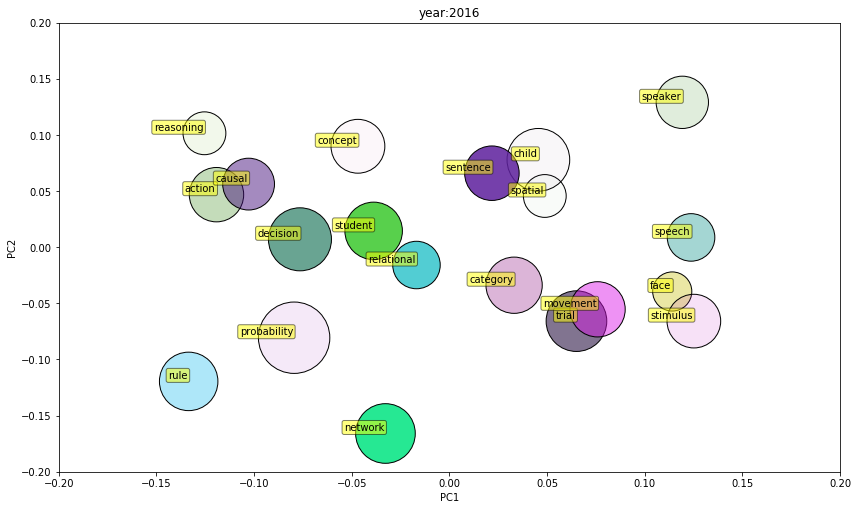

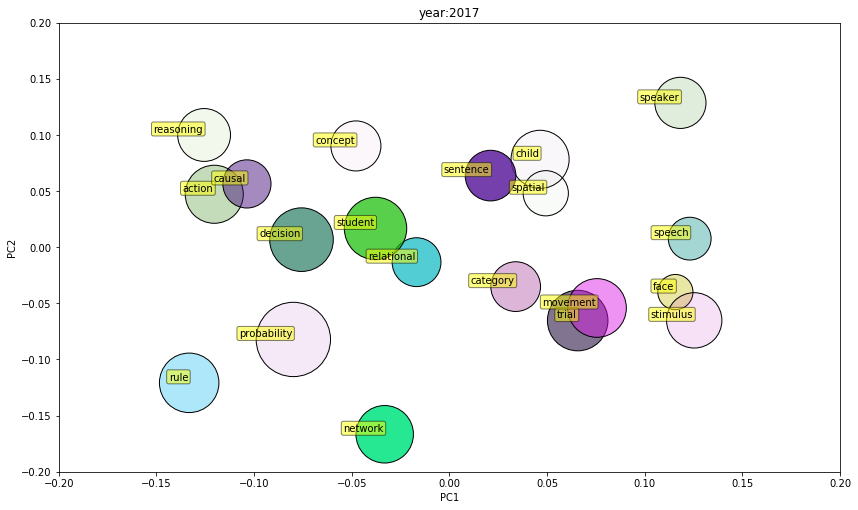

In [98]:
colors = np.random.random((20, 4))
for year in range(18):
    vis_dtm = allvisdtm[year]
    data = vis_dtm[0]['x']
    labels = vis_dtm[0]['topiclabel']
    
    f=plt.figure(figsize=(14, 8))
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(
        vis_dtm[0]['x'], vis_dtm[0]['y'], marker='o', s=vis_dtm[0]['Freq'] * 600, c=colors,edgecolor='k',
        cmap=plt.get_cmap('Spectral'))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim([-0.2,0.2])
    plt.ylim([-0.2,0.2])

    for label, x, y in zip(labels, vis_dtm[0]['x'], vis_dtm[0]['y']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))#,
    #        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.title('year:'+str(2000+year))
    plt.savefig('output/pcoa/year:'+str(2000+year)+'.png')
    plt.show()


In [147]:
# vanilla PCA
# following steps from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
df = pd.DataFrame(columns=terms,index=np.arange(1,21), data=term_topic[year])

x = df.values
# Standardizing the features
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

pcs=pca.components_

firstn=10
for kk in range(len(pcs)):
    print('pc'+str(kk+1)+':')
    print([terms[np.argsort(-abs(pcs[kk]))[k]] for k in range(firstn)])

sum(pca.explained_variance_ratio_)

colors = np.random.random((20, 4))
# plot vanilla pca
for year in range(1):
    # vanilla PCA
    # following steps from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
    df = pd.DataFrame(columns=terms,index=np.arange(1,21), data=term_topic[year])
    x = df.values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    Npc=5
    pca = PCA(n_components=Npc)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['pc'+str(k+1) for k in range(Npc)])
    # principal vectors?
    
    
    vis_dtm = allvisdtm[year]
    labels = vis_dtm[0]['topiclabel']
    
    f=plt.figure(figsize=(14, 8))
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(
        principalDf['pc3'], principalDf['pc2'], marker='o', s=vis_dtm[0]['Freq'] * 600, c=colors,edgecolor='k',
        cmap=plt.get_cmap('Spectral'))
    plt.xlabel('PC3')
    plt.ylabel('PC2')
    #plt.xlim([-0.2,0.2])
    #plt.ylim([-0.2,0.2])

    for label, x, y in zip(labels, principalDf['pc3'], principalDf['pc2']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5))#,
    #        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.title('year:'+str(2000+year))
    plt.savefig('output/pca/year_'+str(2000+year)+'.png')
    plt.show()


In [136]:
# See the explicit principal components
# copied the PCoA and other PC related analysis, from pyLDAvis library. 

# PCoA
def _pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    return [np.sqrt(eigvals) * eigvecs, eigvals]
pcoa = js_PCoA(term_topic[0])

from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

def _jensen_shannon(_P, _Q):
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))


def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    print(dist_matrix.shape)
    return _pcoa(dist_matrix)


def js_MMDS(distributions, **kwargs):
    """Dimension reduction via Jensen-Shannon Divergence & Metric Multidimensional Scaling

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    **kwargs : Keyword argument to be passed to `sklearn.manifold.MDS()`

    Returns
    -------
    mmds : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = MDS(n_components=2, random_state=0, dissimilarity='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)


def js_TSNE(distributions, **kwargs):
    """Dimension reduction via Jensen-Shannon Divergence & t-distributed Stochastic Neighbor Embedding

    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.

    **kwargs : Keyword argument to be passed to `sklearn.manifold.TSNE()`

    Returns
    -------
    tsne : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    model = TSNE(n_components=2, random_state=0, metric='precomputed', **kwargs)
    return model.fit_transform(dist_matrix)

(20, 20)
